In [1]:
import glob, pandas as pd
import matplotlib.pyplot as plt
import pydicom, numpy as np

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

df = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

patient_class = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv', index_col=0)

parsed = parse_data(df)

patientId = df['patientId'][0]
print('Just a checking that everything is working fine...')
print(parsed[patientId])
print(patient_class.loc[patientId])

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

Just a checking that everything is working fine...
{'dicom': '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}
class    No Lung Opacity / Not Normal
Name: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, dtype: object


class    Normal
Name: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, dtype: object


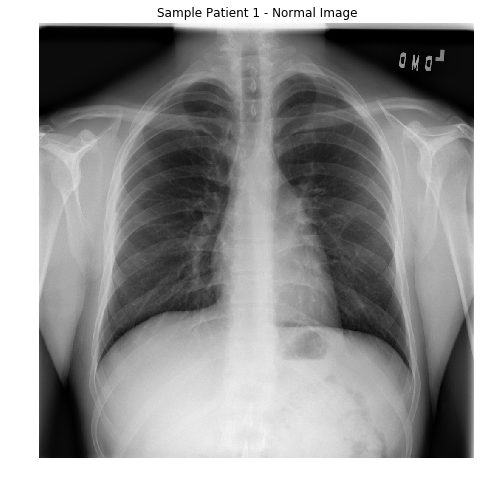

In [2]:
patientId = df['patientId'][3]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 1 - Normal Image")

draw(parsed[patientId])

**Chest Radiographs Basics**

In the process of taking the image, an X-ray passes through the body and reaches a detector on the other side. 
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. 
Dense tissues such as bones absorb the X-rays and appear white in the image. 
In short -

**Black** = Air
**White** = Bone
**Grey** = Tissue or Fluid

The left side of the subject is on the right side of the screen by convention. You can also see the small L at the top of the right corner. 
In a normal image we see the lungs as black, but they have different projections on them - mainly the rib cage bones, main airways, blood vessels and the heart.

                                             class
patientId                                         
00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity


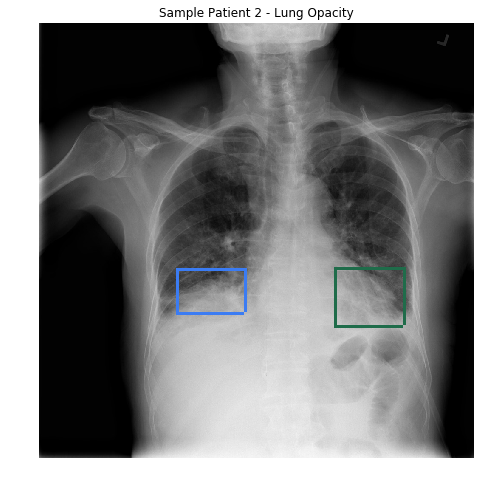

In [3]:
patientId = df['patientId'][8]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 2 - Lung Opacity")

draw(parsed[patientId])

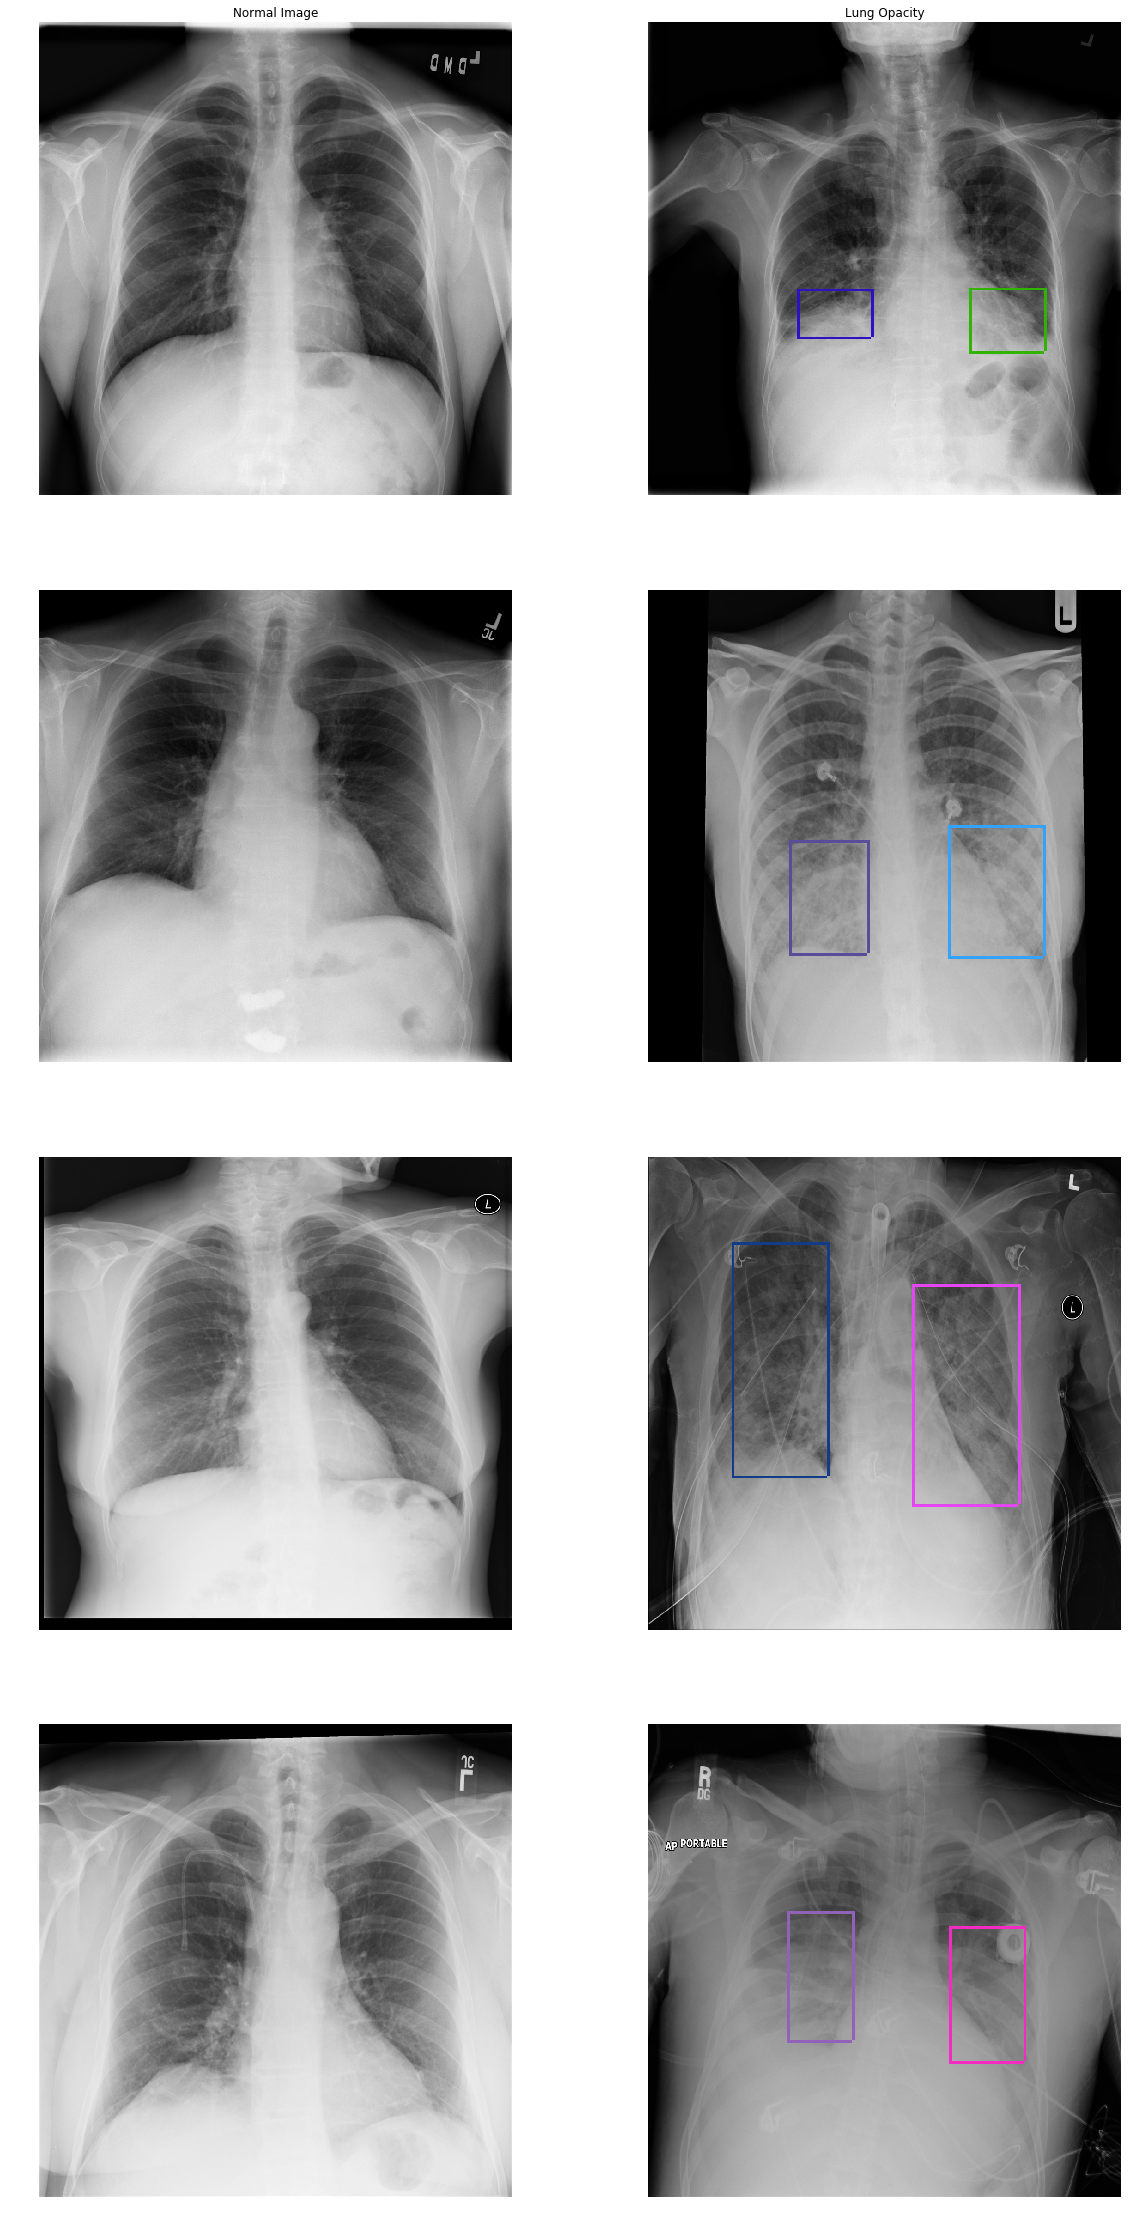

In [4]:
plt.figure(figsize=(20, 40))

plt.subplot(421)
plt.title("Normal Image")

draw(parsed[df['patientId'][3]])

plt.subplot(423)
draw(parsed[df['patientId'][11]])

plt.subplot(425)
draw(parsed[df['patientId'][12]])

plt.subplot(427)
draw(parsed[df['patientId'][13]])

plt.subplot(422)
plt.title("Lung Opacity")

draw(parsed[df['patientId'][8]])

plt.subplot(424)
draw(parsed[df['patientId'][16]])

plt.subplot(426)
draw(parsed[df['patientId'][19]])

plt.subplot(428)
draw(parsed[df['patientId'][24]])

class    No Lung Opacity / Not Normal
Name: 00322d4d-1c29-4943-afc9-b6754be640eb, dtype: object


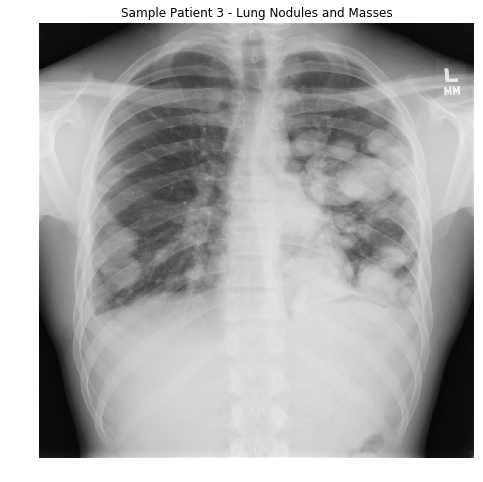

In [5]:
#No Lung Opacity / Not Normal
patientId = df['patientId'][2]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw(parsed[patientId])

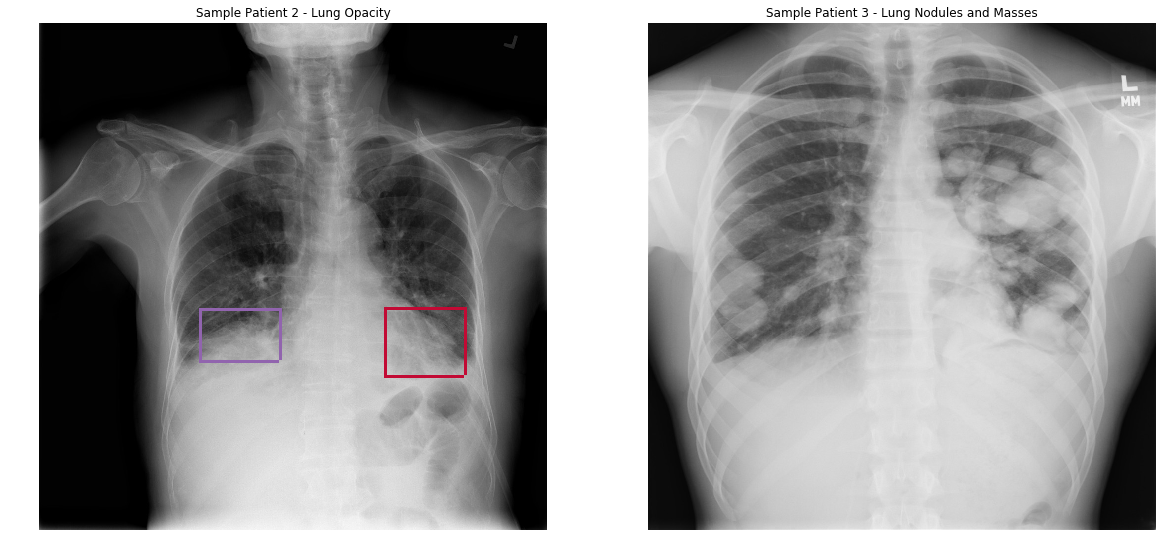

In [6]:
#Uniqueness of Pneumonia associated opacities
plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 2 - Lung Opacity")
draw(parsed[df['patientId'][8]])

plt.subplot(122)
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw(parsed[df['patientId'][2]])

                                             class
patientId                                         
010ccb9f-6d46-4380-af11-84f87397a1b8  Lung Opacity
010ccb9f-6d46-4380-af11-84f87397a1b8  Lung Opacity
                                             class
patientId                                         
012a5620-d082-4bb8-9b3b-e72d8938000c  Lung Opacity
012a5620-d082-4bb8-9b3b-e72d8938000c  Lung Opacity


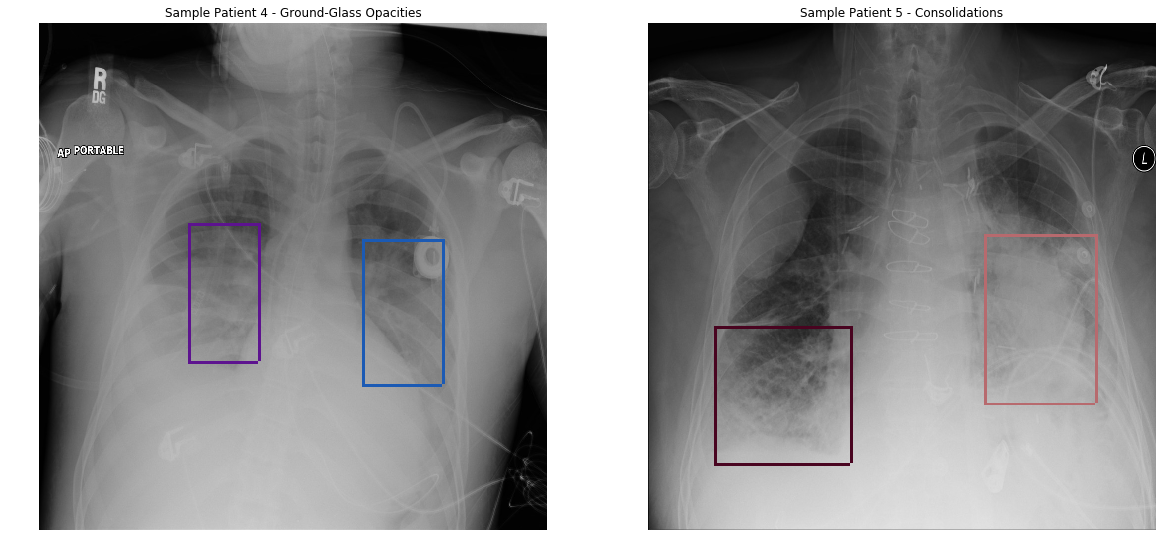

In [7]:
#Consolidation vs. Ground-Glass Opacity
plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 4 - Ground-Glass Opacities")
draw(parsed[df['patientId'][25]])
print(patient_class.loc[df['patientId'][25]])

plt.subplot(122)
plt.title("Sample Patient 5 - Consolidations")
draw(parsed[df['patientId'][28]])
print(patient_class.loc[df['patientId'][28]])

class    Normal
Name: 01cc7c75-4498-43ab-b650-5553d0507f76, dtype: object
class    No Lung Opacity / Not Normal
Name: 03ab53d0-0a93-43f7-bfb7-4fc5b4db75dc, dtype: object


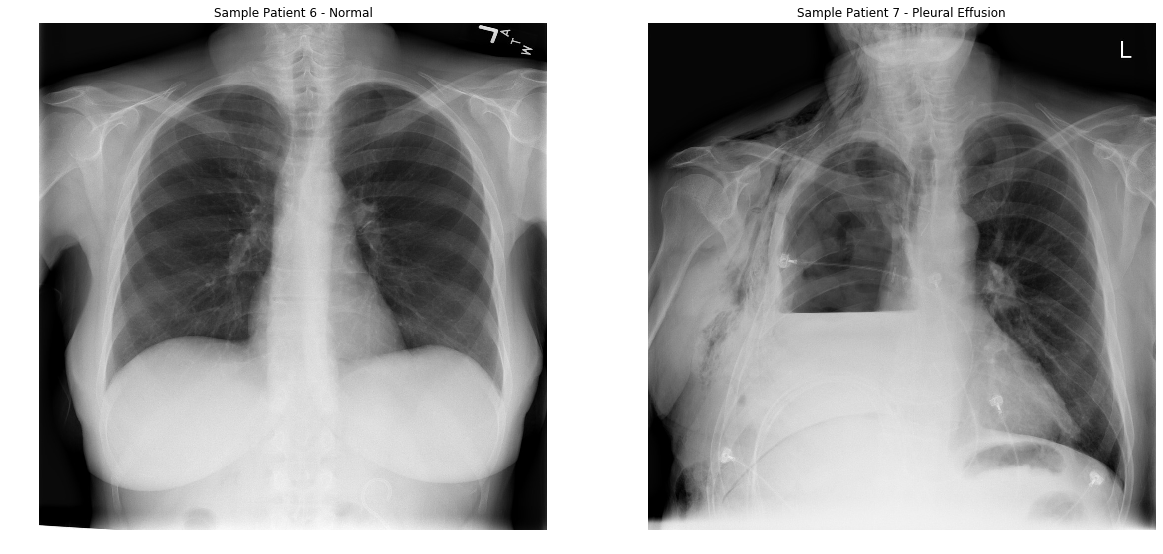

In [8]:
#Opacities That Are Not Related to Pneumonia

plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw(parsed[df['patientId'][59]])
print(patient_class.loc[df['patientId'][59]])

plt.subplot(122)
plt.title("Sample Patient 7 - Pleural Effusion")
draw(parsed[df['patientId'][125]])
print(patient_class.loc[df['patientId'][125]])

class    Normal
Name: 01cc7c75-4498-43ab-b650-5553d0507f76, dtype: object
class    No Lung Opacity / Not Normal
Name: 00322d4d-1c29-4943-afc9-b6754be640eb, dtype: object


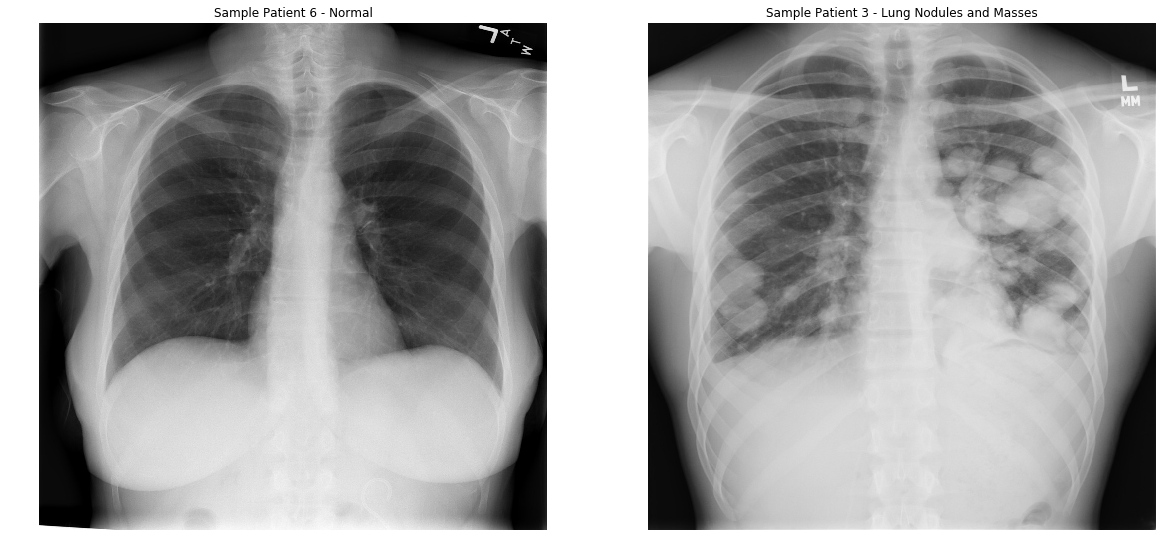

In [9]:
#Lung Masses and Nodules

plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw(parsed[df['patientId'][59]])
print(patient_class.loc[df['patientId'][59]])

plt.subplot(122)
plt.title("Sample Patient 3 - Lung Nodules and Masses")
draw(parsed[df['patientId'][2]])
print(patient_class.loc[df['patientId'][2]])

class    Normal
Name: 01cc7c75-4498-43ab-b650-5553d0507f76, dtype: object
class    No Lung Opacity / Not Normal
Name: 019e035e-2f82-4c66-a198-57422a27925f, dtype: object


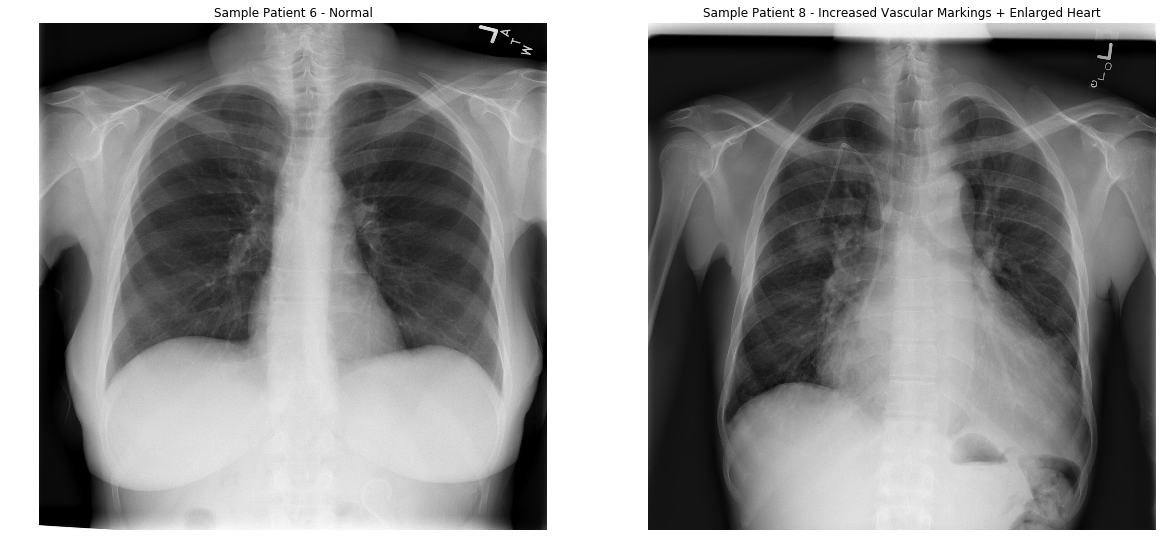

In [10]:
#Increased Vascular Markings + Enlarged Heart
plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw(parsed[df['patientId'][59]])
print(patient_class.loc[df['patientId'][59]])

plt.subplot(122)
plt.title("Sample Patient 8 - Increased Vascular Markings + Enlarged Heart")
draw(parsed[df['patientId'][38]])
print(patient_class.loc[df['patientId'][38]])

class    Normal
Name: 01cc7c75-4498-43ab-b650-5553d0507f76, dtype: object
class    Lung Opacity
Name: 924f4f8b-fc27-4dfd-b5ae-59c40715e150, dtype: object
class    Lung Opacity
Name: 17a5ce04-809a-42ed-9e58-100cfb33de7a, dtype: object
class    Lung Opacity
Name: 9dde630b-1f95-46e6-bcde-117eee4c7283, dtype: object


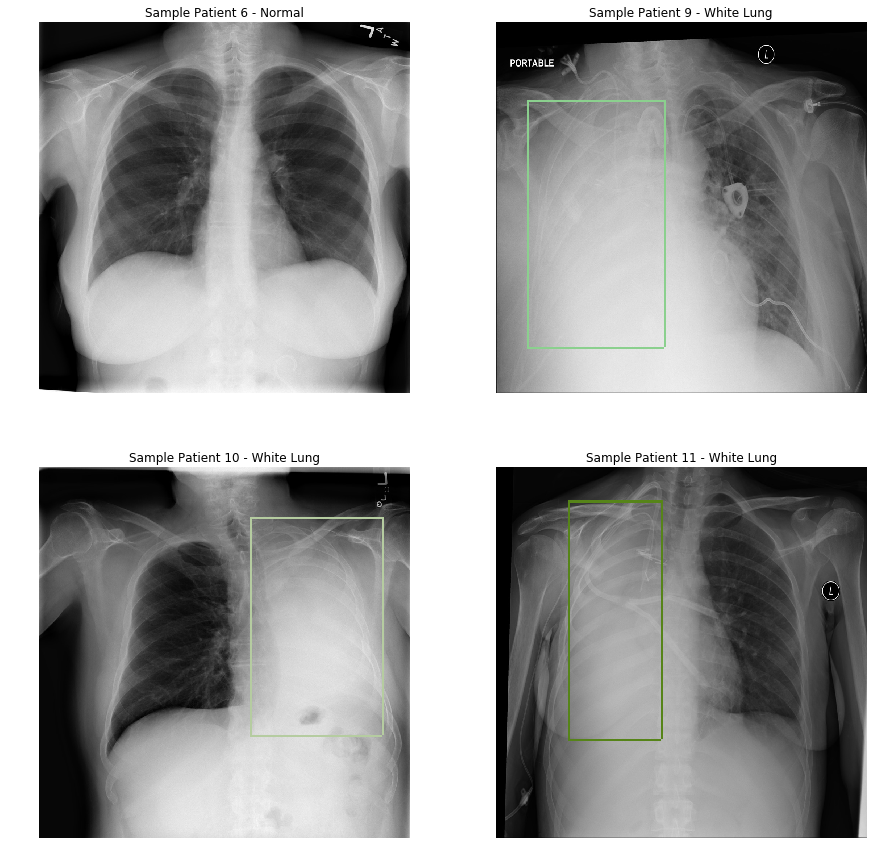

In [11]:
#White-Lung
plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.title("Sample Patient 6 - Normal")
draw(parsed[df['patientId'][59]])
print(patient_class.loc[df['patientId'][59]])

plt.subplot(222)
plt.title("Sample Patient 9 - White Lung")
draw(parsed['924f4f8b-fc27-4dfd-b5ae-59c40715e150'])
print(patient_class.loc['924f4f8b-fc27-4dfd-b5ae-59c40715e150'])

plt.subplot(223)
plt.title("Sample Patient 10 - White Lung")
draw(parsed['17a5ce04-809a-42ed-9e58-100cfb33de7a'])
print(patient_class.loc['17a5ce04-809a-42ed-9e58-100cfb33de7a'])

plt.subplot(224)
plt.title("Sample Patient 11 - White Lung")
draw(parsed['9dde630b-1f95-46e6-bcde-117eee4c7283'])
print(patient_class.loc['9dde630b-1f95-46e6-bcde-117eee4c7283'])

class    Normal
Name: 01cc7c75-4498-43ab-b650-5553d0507f76, dtype: object
class    No Lung Opacity / Not Normal
Name: 01a5594f-e5d4-4f7a-b79d-3f57559fe37b, dtype: object


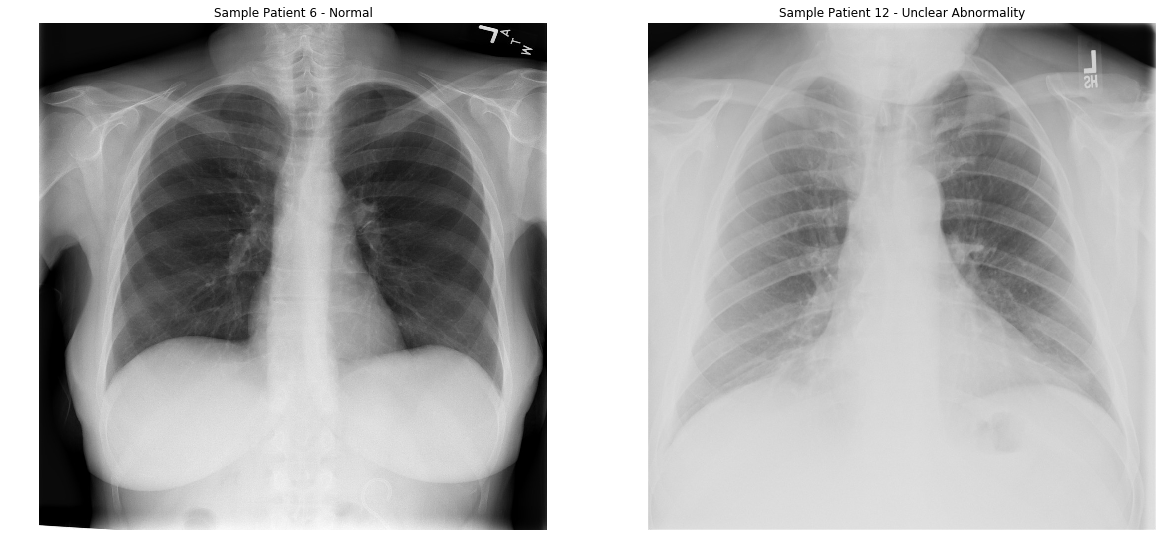

In [12]:
#Unclear Abnormality

plt.figure(figsize=(20, 40))

plt.subplot(121)
plt.title("Sample Patient 6 - Normal")
draw(parsed[df['patientId'][59]])
print(patient_class.loc[df['patientId'][59]])

plt.subplot(122)
plt.title("Sample Patient 12 - Unclear Abnormality")
draw(parsed[df['patientId'][40]])
print(patient_class.loc[df['patientId'][40]])

In [13]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [14]:
DATA_DIR = '/kaggle/input/rsna-pneumonia-detection-challenge'

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

In [15]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.90 MiB | 31.86 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [16]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [17]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [18]:
### Download COCO pre-trained weights
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


**Some setup functions and classes for Mask-RCNN**

dicom_fps is a list of the dicom image path and filenames
image_annotions is a dictionary of the annotations keyed by the filenames
parsing the dataset returns a list of the image filenames and the annotations dictionary

In [19]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [20]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [21]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [22]:
#Training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [23]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [24]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [25]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.9537.1517874343.642446
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'f174000f-f9e2-4f80-941b-a11c1ca45c4d'
(0010, 0020) Patient ID                          LO: 'f174000f-f9e2-4f80-941b-a11c1ca45c4d'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [26]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

Split the data into training and validation datasets

In [27]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


Create and prepare the training dataset using the DetectorDataset class.

In [28]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [29]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    3606dcdc-56a2-405f-b799-2f7e13d1b2e8
 x                                             577
 y                                             571
 width                                         242
 height                                        261
 Target                                          1
 Name: 3087, dtype: object, patientId    3606dcdc-56a2-405f-b799-2f7e13d1b2e8
 x                                             240
 y                                              82
 width                                         238
 height                                        676
 Target                                          1
 Name: 3088, dtype: object]

In [30]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

Display a random image with bounding boxes

(1024, 1024, 3)
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/0965f1e9-2905-40ef-8612-4984e2c7e9ea.dcm
[1]


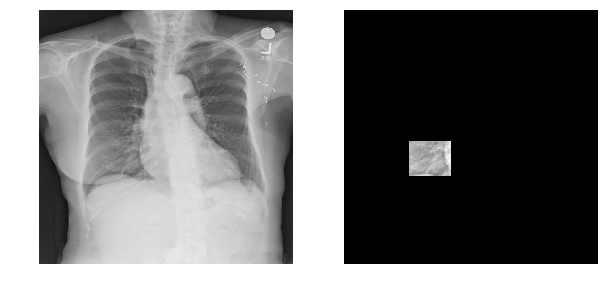

In [31]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

Image Augmentation. Try finetuning some variables to custom values

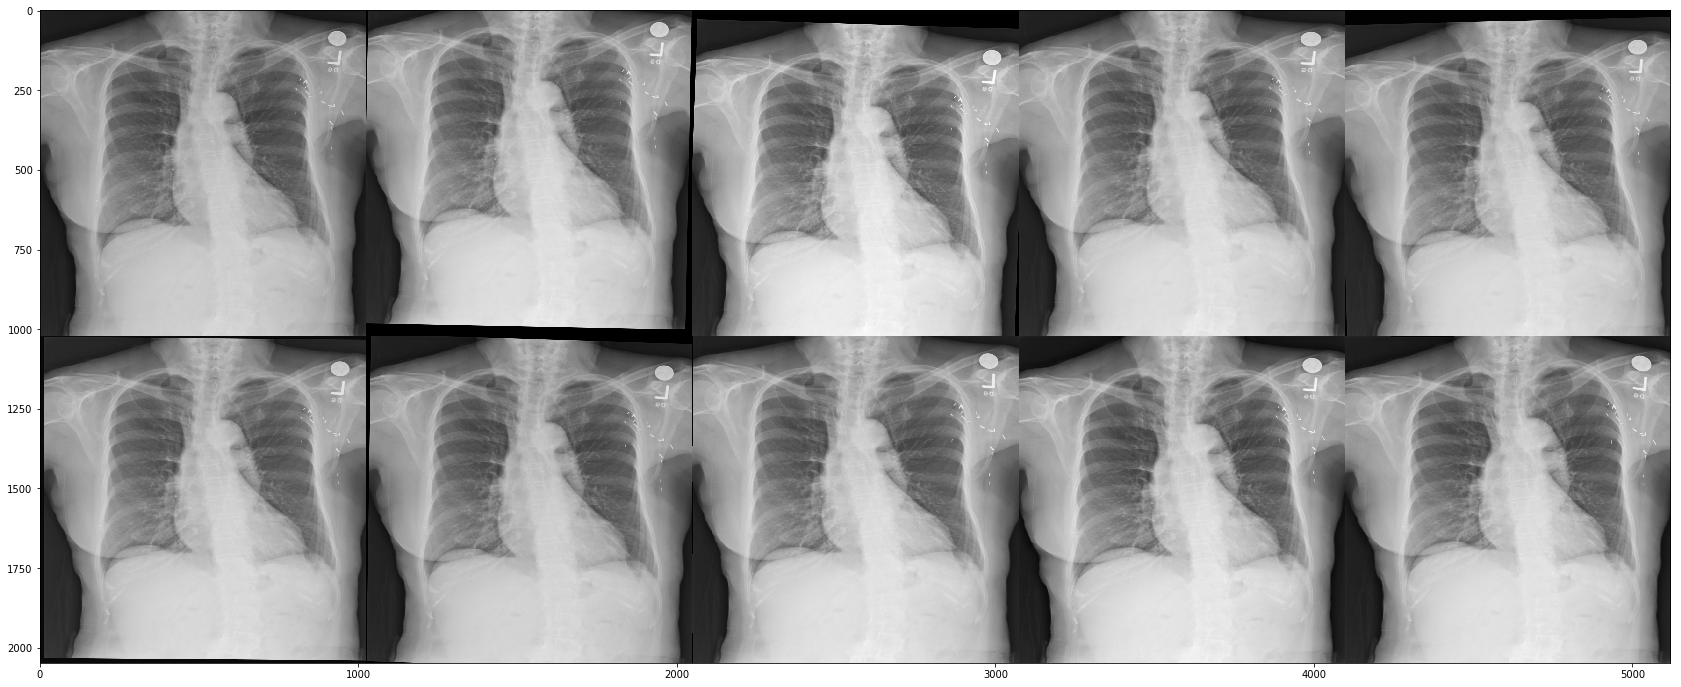

In [32]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [33]:
#Train the model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [34]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [35]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /kaggle/working/pneumonia20191016T2032/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

AttributeError: 'Model' object has no attribute 'metrics_tensors'

In [36]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.006

Checkpoint Path: /kaggle/working/pneumonia20191016T2032/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

AttributeError: 'Model' object has no attribute 'metrics_tensors'

In [37]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.0012000000000000001

Checkpoint Path: /kaggle/working/pneumonia20191016T2032/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

AttributeError: 'Model' object has no attribute 'metrics_tensors'

In [38]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

NameError: name 'history' is not defined

NameError: name 'epochs' is not defined

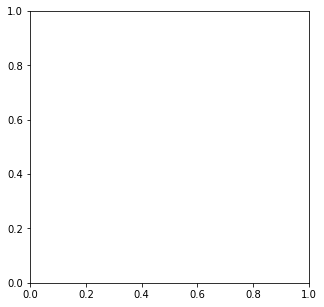

In [39]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [40]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

NameError: name 'history' is not defined

In [41]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in /kaggle/working/pneumonia20191016T2032


IndexError: list index out of range

In [42]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

NameError: name 'model_path' is not defined

In [43]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)

*** No instances to display *** 



InvalidArgumentError: indices[4867] = 16339 is not in [0, 16320)
	 [[{{node ROI_1/GatherV2_2}}]]

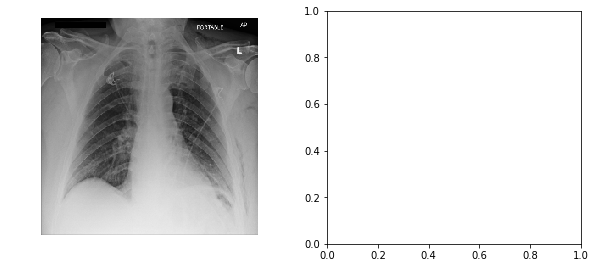

In [44]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [45]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [46]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

NameError: name 'test_image_fps' is not defined

In [47]:
output = pd.read_csv(submission_fp)
output.head(60)

FileNotFoundError: [Errno 2] File b'/kaggle/working/submission.csv' does not exist: b'/kaggle/working/submission.csv'

In [48]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

NameError: name 'test_image_fps' is not defined

In [49]:
# remove files to allow committing (hit files limit otherwise)
!rm -rf /kaggle/working/Mask_RCNN